In [1]:
import deeplift
import deeplift.blobs as blobs
import sys, os
scriptsDir = os.environ.get("KERAS_DIR");                                       
if (scriptsDir is None):                                                        
    raise Exception("Please set environment variable KERAS_DIR to point to deeplearning repo");
sys.path.insert(0,scriptsDir);
import keras
from keras.models import model_from_yaml
import numpy as np

#yaml_file = "modelsDir_runs/record_0_model_i4fMH_modelYaml.yaml"
#weights_file = "modelsDir_runs/record_0_model_i4fMH_modelWeights.h5"
yaml_file = "modelsDir_runs/record_1_model_OVBbe_modelYaml.yaml"
weights_file = "modelsDir_runs/record_1_model_OVBbe_modelWeights.h5"
model = model_from_yaml(open(yaml_file).read())
model.load_weights(weights_file)

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
Using Theano backend.


In [2]:
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to the deeplift code");
sys.path.insert(0,scriptsDir);
from importDataPackage import importData
trainData, validData, testData = importData.loadTrainTestValidFromYaml("yaml/features.yaml",
                                                                       "yaml/labels.yaml",
                                                                       "yaml/splits.yaml")

(0, 'rows skipped from', 'features.gz')
Returning desired dict
Making numpy arrays out of the loaded files
('train', 'shapeX', (80000, 2))
('train', 'shapeY', (80000, 1))
('valid', 'shapeX', (10000, 2))
('valid', 'shapeY', (10000, 1))
('test', 'shapeX', (10000, 2))
('test', 'shapeY', (10000, 1))


In [3]:
model.layers[0].get_weights()

[array([[[-2.14597249],
         [-2.14224005]],
 
        [[-0.00792655],
         [ 0.02660598]],
 
        [[ 2.18723059],
         [-2.133322  ]],
 
        [[-2.14895868],
         [ 2.18371677]],
 
        [[ 2.18499517],
         [ 2.16541862]]], dtype=float32), array([[-1.67921031],
        [ 0.28924084],
        [-1.72633326],
        [-1.74228311],
        [-1.77093565]], dtype=float32)]

/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


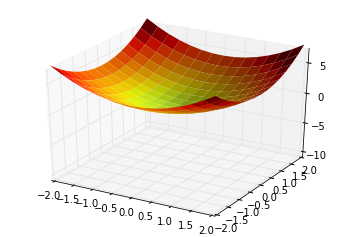

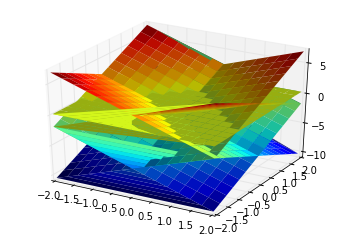

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
points=15
x = np.outer(np.linspace(-2, 2, points), np.ones(points))
y = x.copy().T

weights_arr, biases_arr = model.layers[0].get_weights()

fullx = []
fully = []
fullz = []
for weights, bias in zip(weights_arr, biases_arr):
    z = weights[0][0]*x + weights[1][0]*y + bias
    fullx.append(x)
    fully.append(y)
    fullz.append(z)
    #reverse x and y so that, the next time, adjacent points on the xy coordinates are getting tacked on
    #(I think the surface plotting expects at least x and y to be somewhat continuous)
    #(doing this results in a much more uniform color map)
    x=x[::-1,::-1] 
    y=y[::-1,::-1]
x_all = np.concatenate(fullx, axis=-1)
y_all = np.concatenate(fully, axis=-1)
z_all = np.concatenate(fullz, axis=-1)
vmin = np.min(z_all)
vmax = np.max(z_all)

z = x ** 2 + y ** 2
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_zlim(bottom=vmin, top=vmax)
ax.plot_surface(x, y, z, facecolors=plt.get_cmap('jet')((z-vmin)/(vmax-vmin)), rstride=1, cstride=1, linewidth=0)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_zlim(bottom=vmin, top=vmax)
ax.plot_surface(x_all, y_all, z_all, facecolors=plt.get_cmap('jet')((z_all-vmin)/(vmax-vmin)),
                rstride=1, cstride=1, linewidth=0)



In [28]:
import deeplift.blobs as blobs
input_layer = blobs.Input_FixedDefault(default=0.0, num_dims=None, shape=(None, 2))
dense_nodes = []
feature_weights = model.layers[0].get_weights()[0]
feature_biases = model.layers[0].get_weights()[1]
for i in range(len(feature_weights)):
    dense_nodes.append(blobs.Dense(W=feature_weights[i], b=feature_biases[i]))
    dense_nodes[-1].set_inputs(input_layer)
merge_layer = blobs.MaxMerge(axis=1, temp=1.0)
merge_layer.set_inputs(dense_nodes)
merge_layer.build_fwd_pass_vars()
merge_layer.set_scoring_mode(blobs.ScoringMode.OneAndZeros)
merge_layer.set_active()
input_layer.update_mxts()

In [6]:
import theano
keras_fprop = theano.function([model.layers[0].input], model.layers[-1].get_output(train=False), allow_input_downcast=True)

In [7]:
deeplift_fprop = theano.function([input_layer.get_activation_vars()], merge_layer.get_activation_vars(), allow_input_downcast=True)

In [8]:
import numpy as np
print(np.max(np.abs(np.array(keras_fprop(validData.X))-np.array(deeplift_fprop(validData.X)))))

9.53674e-07


In [29]:
deeplift_contribs_func = theano.function([input_layer.get_activation_vars()], input_layer.get_target_contrib_vars(), allow_input_downcast=True)

In [10]:
grad_times_inp_func = theano.function([model.layers[0].input], theano.grad(theano.tensor.sum(model.layers[-1].get_output(train=False)[:,0]),
                                                                      model.layers[0].input)*model.layers[0].input, allow_input_downcast=True)

In [30]:
#square_contribs = np.square(validData.X)
#sum_square = np.sum(square_contribs, axis=1)
#true_contribs = square_contribs/(sum_square[:,None])*deeplift_fprop(validData.X)[:,None]
true_contribs = np.square(validData.X)
deeplift_contribs = deeplift_contribs_func(validData.X)
grad_times_inp = grad_times_inp_func(validData.X)

In [23]:
import deeplift.blobs as blobs
reload(blobs.maxout)
reload(blobs)
input_layer2 = blobs.Input_FixedDefault(default=0.0, num_dims=None, shape=(None, 2))
maxout_layer = blobs.Maxout(W=model.layers[0].get_weights()[0], b=model.layers[0].get_weights()[1])
maxout_layer.set_inputs(input_layer2)
maxout_layer.build_fwd_pass_vars()
maxout_layer.set_scoring_mode(blobs.ScoringMode.OneAndZeros)
maxout_layer.set_active()
input_layer2.update_mxts()

In [24]:
deeplift_fprop2 = theano.function([input_layer2.get_activation_vars()], maxout_layer.get_activation_vars(), allow_input_downcast=True)
print(np.max(np.abs(np.array(keras_fprop(validData.X))-np.array(deeplift_fprop2(validData.X)))))

0.0


In [25]:
deeplift_contribs_func2 = theano.function([input_layer2.get_activation_vars()], input_layer2.get_target_contrib_vars(), allow_input_downcast=True)
deeplift_contribs2 = deeplift_contribs_func2(validData.X)

In [31]:
print(np.mean(np.square(true_contribs-deeplift_contribs)))
print(np.mean(np.square(true_contribs-deeplift_contribs2)))
print(np.mean(np.square(true_contribs-grad_times_inp)))

0.183916845131
0.208010275115
0.749292211639


In [32]:
for temp in [0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 10, 100, 200, 300]:
    input_layer = blobs.Input_FixedDefault(default=0.0, num_dims=None, shape=(None, 2))
    dense_nodes = []
    feature_weights = model.layers[0].get_weights()[0]
    feature_biases = model.layers[0].get_weights()[1]
    for i in range(len(feature_weights)):
        dense_nodes.append(blobs.Dense(W=feature_weights[i], b=feature_biases[i]))
        dense_nodes[-1].set_inputs(input_layer)
    merge_layer = blobs.MaxMerge(axis=1, temp=temp)
    merge_layer.set_inputs(dense_nodes)
    merge_layer.build_fwd_pass_vars()
    merge_layer.set_scoring_mode(blobs.ScoringMode.OneAndZeros)
    merge_layer.set_active()
    input_layer.update_mxts()
    deeplift_contribs_func = theano.function(
        [input_layer.get_activation_vars()],
        input_layer.get_target_contrib_vars(),
        allow_input_downcast=True)
    deeplift_contribs = deeplift_contribs_func(validData.X)
    print(temp, np.mean(np.square(true_contribs-deeplift_contribs)))

(0.08, 0.2076980089584099)
(0.1, 0.20754122478784839)
(0.2, 0.20619017411689719)
(0.4, 0.20124870898458097)
(0.6, 0.1949926605015215)
(0.8, 0.1890023833281797)
(1, 0.18391684513053436)
(1.2, 0.17978879676531387)
(1.4, 0.1764736867352999)
(1.6, 0.17380066401202371)
(1.8, 0.17162374765003413)
(10, 0.15643206557261138)
(100, 0.15358852988892022)
(200, 0.15343599292000626)
(300, 0.15338558319480033)
